# GRIP-The Sparks Foundation

Data Science and Business Analyts Internship

Task-5  Prediction using Decision Tree

Author:- Prit Rameshbhai Sheta

Dataset = Iris

In [1]:
import pandas as pd                                    # for loading dataset
import numpy as np                                     # for numerical computation
from matplotlib import pyplot as plt                   # visualize tool
import seaborn as sns                                  # visualize tool
import sklearn.metrics as sm


from statsmodels.stats.outliers_influence import variance_inflation_factor  # to calculate VIF

from sklearn.model_selection import train_test_split  # to split data into train and test sets
from sklearn.model_selection import GridSearchCV      # to perform hyper-parameter optimization
from sklearn.tree import DecisionTreeClassifier, export_graphviz      # Decision Tree model for classfication

from sklearn.metrics import confusion_matrix, plot_confusion_matrix   # to draw confusion matrix
from sklearn.metrics import classification_report      # breif report about DTC model
from sklearn.tree import plot_tree                 # to draw Decision Tree
from sklearn.model_selection import cross_val_score  # to perform cross validation

import joblib  # to save DTC model
import pydot
from IPython.display import Image

import warnings # ignoring warnings
warnings.filterwarnings("ignore")

# Import Data set

In [2]:
iris = pd.read_csv('Iris-2.csv', index_col='Id')
iris.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
Id,,,,,
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa
5,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
iris.shape

(150, 5)

In [4]:
iris.dtypes


SepalLengthCm    float64
SepalWidthCm     float64
PetalLengthCm    float64
PetalWidthCm     float64
Species           object
dtype: object

In [5]:
iris.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 1 to 150
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SepalLengthCm  150 non-null    float64
 1   SepalWidthCm   150 non-null    float64
 2   PetalLengthCm  150 non-null    float64
 3   PetalWidthCm   150 non-null    float64
 4   Species        150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 7.0+ KB


In [6]:
iris.describe()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [7]:
iris.isnull().sum()

SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

# Numerical and Categorical features/ Variables

In [8]:
numerical_col = [col for col in iris.columns if iris[col].dtype!='O']
categorical_col = [col for col in iris.columns if iris[col].dtype=='O']

print(f"Numberical columns are = {numerical_col}")
print(f"Categorical columns are = {categorical_col}")

Numberical columns are = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
Categorical columns are = ['Species']


In [9]:
continuous_col = [col for col in numerical_col if iris[col].nunique() >= 25]
discrete_col = [col for col in numerical_col if iris[col].nunique() < 25]

print(f"Continuous values features are = {continuous_col}")
print(f"Discrete values feature is = {discrete_col}")

Continuous values features are = ['SepalLengthCm', 'PetalLengthCm']
Discrete values feature is = ['SepalWidthCm', 'PetalWidthCm']


# Visualizing Data

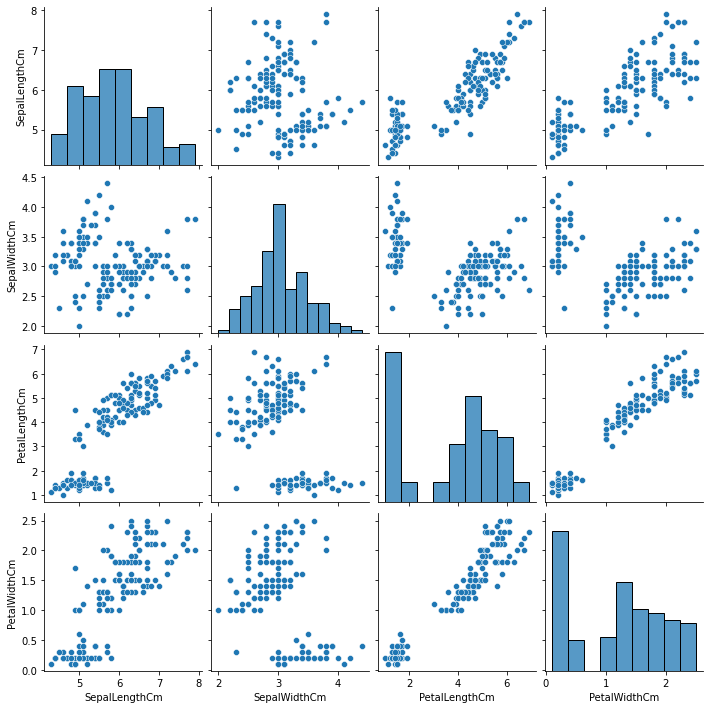

In [10]:
# Input data Visualization
sns.pairplot(data=iris)

checking for imbalance data

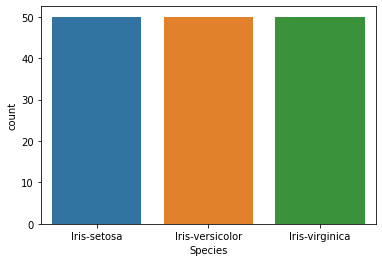

In [11]:
sns.countplot(x ='Species', data=iris)


We have equal no of counts of each class.



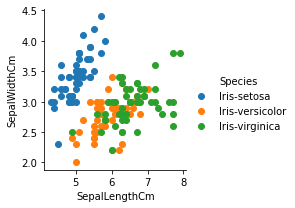

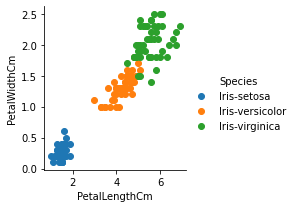

In [12]:
# Scatter plot of data based on Sepal Length and Width features
sns.FacetGrid(iris,hue='Species').map(plt.scatter,'SepalLengthCm','SepalWidthCm').add_legend()
plt.show()

# Scatter plot of data based on Petal Length and Width features
sns.FacetGrid(iris,hue='Species').map(plt.scatter,'PetalLengthCm','PetalWidthCm').add_legend()
plt.show()

# Outliers

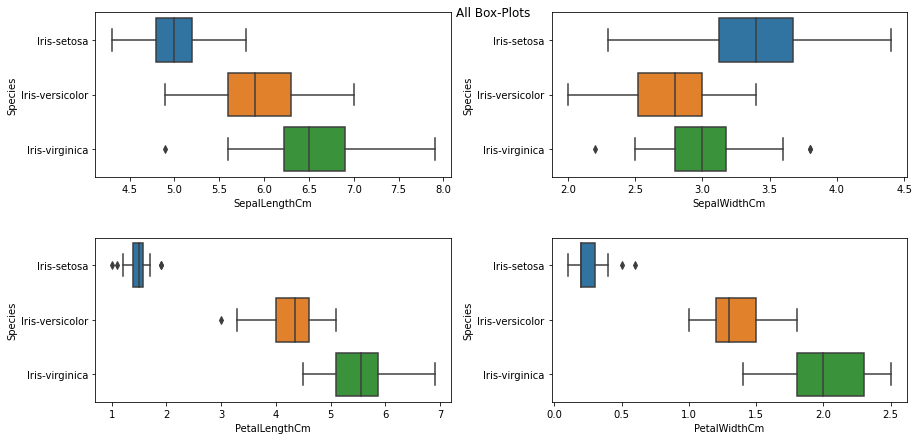

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
fig.tight_layout(h_pad=4, w_pad=7)
plt.suptitle('All Box-Plots')

for i in range(2):
    for j in range(2):
        index = 2*i +j
        sns.boxplot(y='Species', x=iris.iloc[:, index], data=iris, ax=ax[i, j])
plt.show()

There exist few outliers in data. Majority in 'PetalLengthcm'. Decision Tree don't get affected by outliers, unlike (KNN).Thats why not removing outliers.



# Distribution of the Numerical Variables


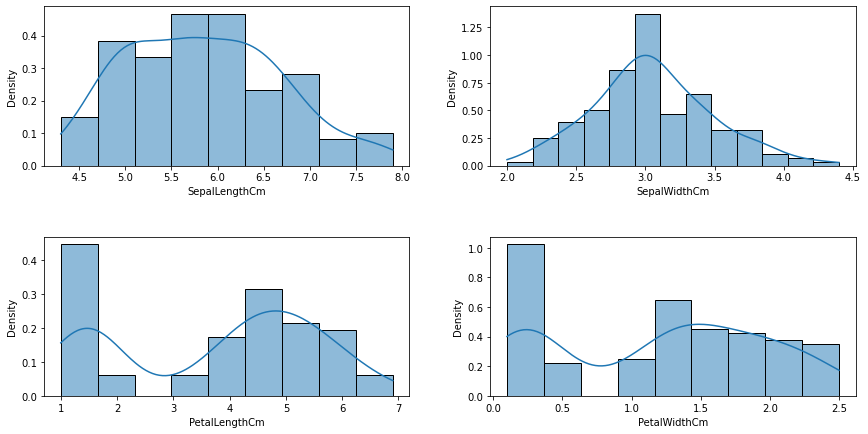

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
fig.tight_layout(h_pad=5, w_pad=5)


for i in range(2):
    for j in range(2):
        index = 2*i +j
        sns.histplot(iris.iloc[:, index], ax=ax[i, j], kde=True, stat="density")

SepalLengthCm and SepalWidthCm both follows normal distribution, but PetalLengthCm and PetalWidthCm do not follow normal distribution.



# Peparing Data for Model


In [15]:
unique_types_iris = iris['Species'].unique()
unique_types = [x.replace('Iris-', '') for x in unique_types_iris]
unique_types

['setosa', 'versicolor', 'virginica']

In [16]:
mapper = {unique_types_iris[x]:x for x in range(len(unique_types))}
mapper

{'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}

# Dividing Data into X(independent variables) and y(dependent variable)


In [17]:
X = iris.iloc[:, :-1]
y = iris.iloc[:, -1]

# Decision Tree Model Training



In [18]:
# Model Training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0) 
tree_classifier = DecisionTreeClassifier()
tree_classifier.fit(X_train,y_train)
print("Training Complete.")
y_pred = tree_classifier.predict(X_test)

Training Complete.


In [19]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}) 
df

,Actual,Predicted
Id,,
115,Iris-virginica,Iris-virginica
63,Iris-versicolor,Iris-versicolor
34,Iris-setosa,Iris-setosa
108,Iris-virginica,Iris-virginica
8,Iris-setosa,Iris-setosa
101,Iris-virginica,Iris-virginica
41,Iris-setosa,Iris-setosa
87,Iris-versicolor,Iris-versicolor
77,Iris-versicolor,Iris-versicolor


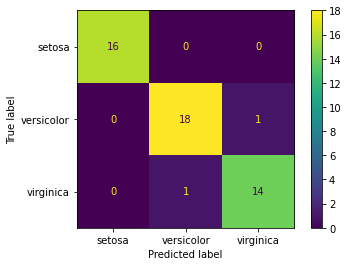

In [20]:
plot_confusion_matrix(tree_classifier,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=unique_types)
plt.show()

In [21]:
y_pred = tree_classifier.predict(X_test)

print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        16
Iris-versicolor       0.95      0.95      0.95        19
 Iris-virginica       0.93      0.93      0.93        15

       accuracy                           0.96        50
      macro avg       0.96      0.96      0.96        50
   weighted avg       0.96      0.96      0.96        50



# Applying HyperParameter Optimization using GridSearchCv


In [22]:
max_depth = range(1, 10)
min_samples_split = range(1, 10)
min_samples_leaf = range(1, 5)

params =   {
            'max_depth': max_depth,
            'min_samples_split':min_samples_split,
            'min_samples_leaf':min_samples_leaf,
           }

optimal_params = GridSearchCV(DecisionTreeClassifier(),
                              params,
                              cv=10,
                              scoring='accuracy',
                              verbose=0,
                              n_jobs=-1,
                                )

optimal_params.fit(X_train, y_train)

print('GridSearch CV best score : {:.4f}\n\n'.format(optimal_params.best_score_))

print('Parameters that give the best results :','\n\n', (optimal_params.best_params_))

GridSearch CV best score : 0.9500


Parameters that give the best results : 

 {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 4}


In [23]:
tree_classifier = DecisionTreeClassifier(random_state=42, **optimal_params.best_params_)
tree_classifier.fit(X_train, y_train)

tree_classifier.score(X_test, y_test)


0.98

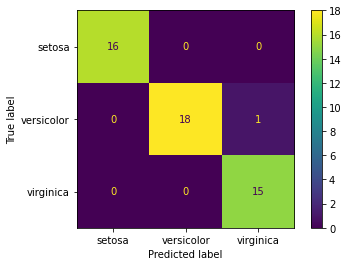

In [24]:
plot_confusion_matrix(tree_classifier,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=unique_types)

In [25]:
y_pred = tree_classifier.predict(X_test)

print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        16
Iris-versicolor       1.00      0.95      0.97        19
 Iris-virginica       0.94      1.00      0.97        15

       accuracy                           0.98        50
      macro avg       0.98      0.98      0.98        50
   weighted avg       0.98      0.98      0.98        50



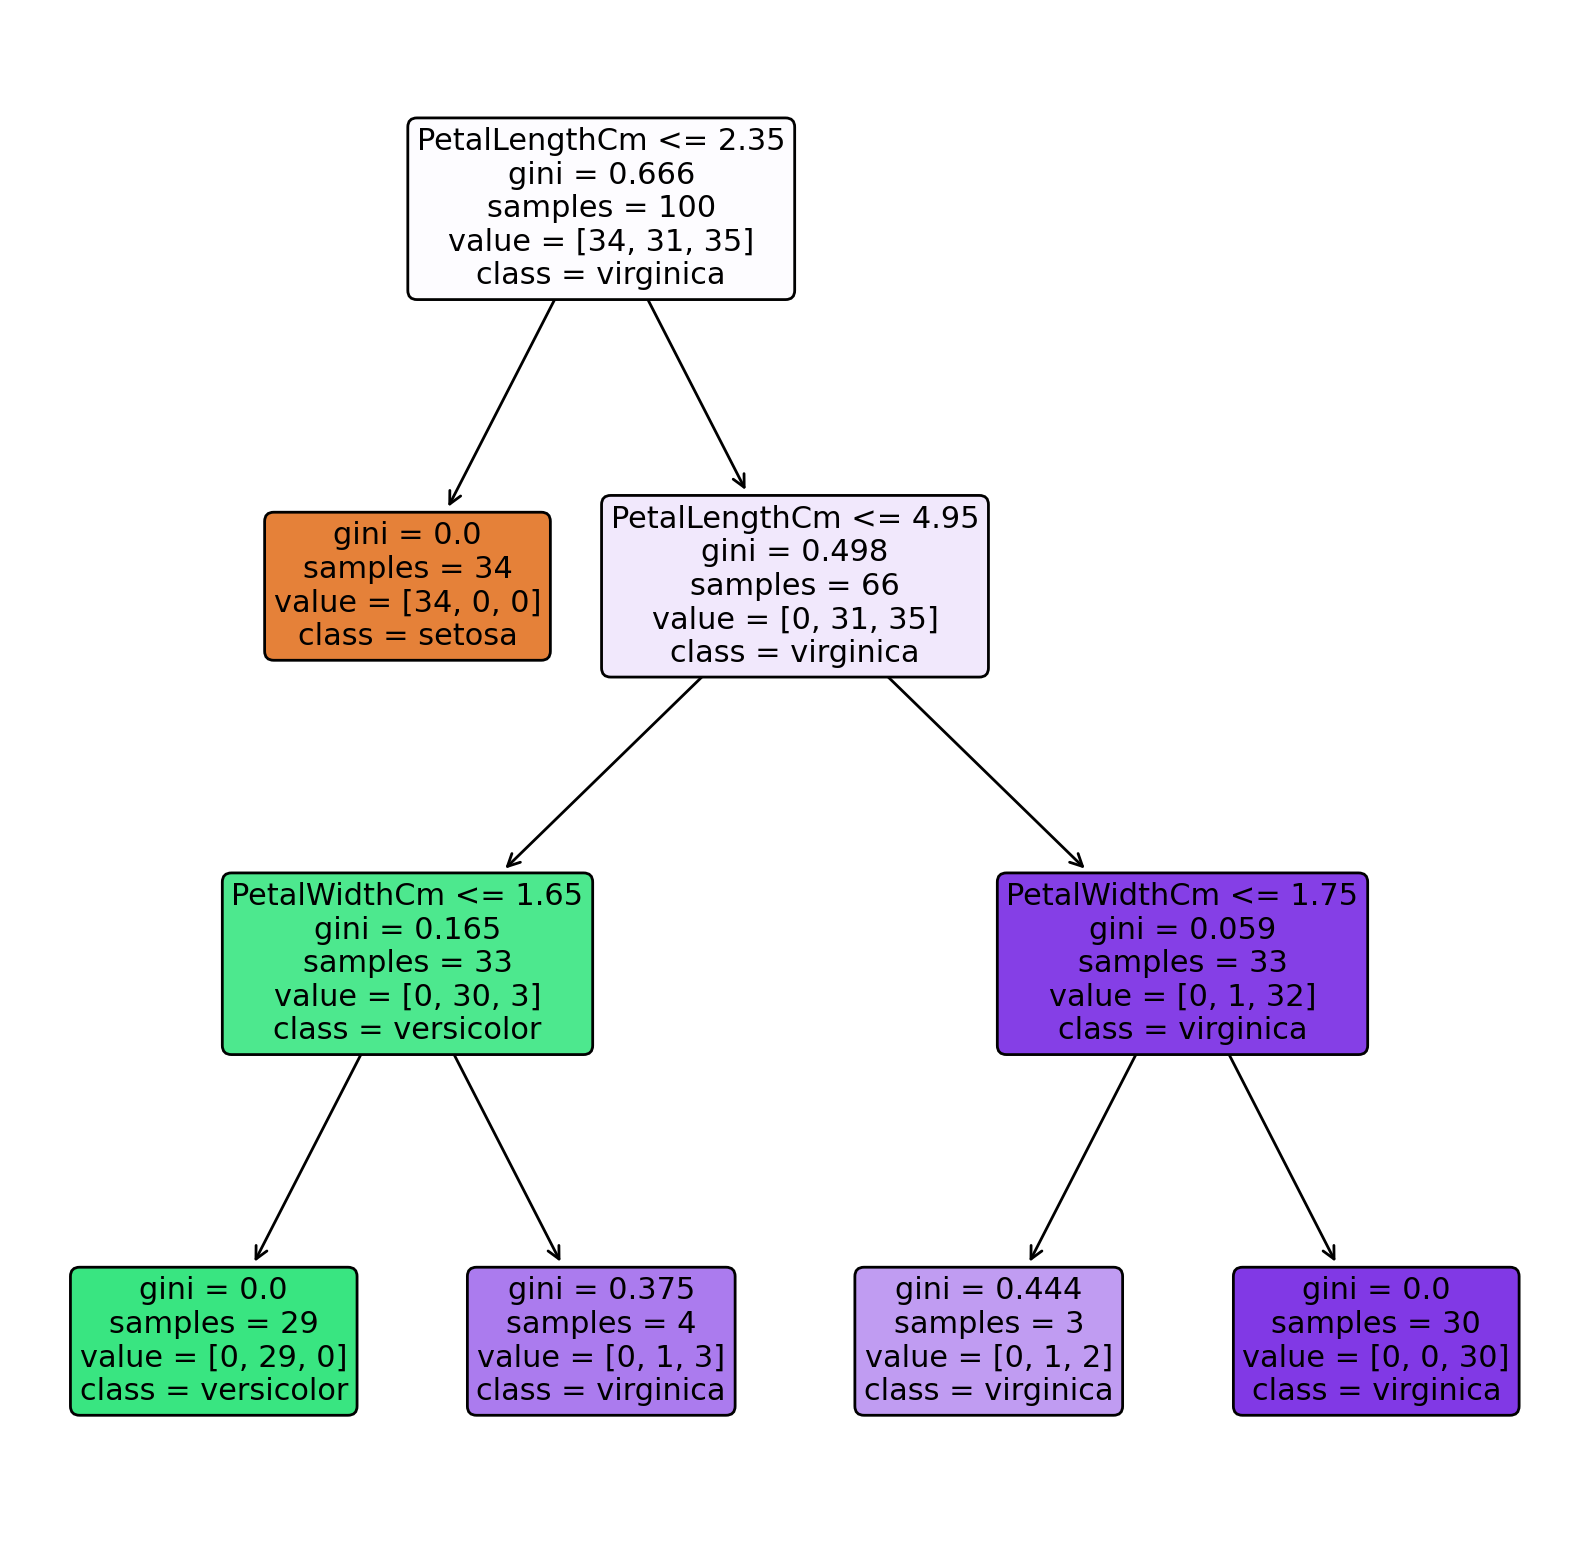

In [26]:
#Visualizing the trained Decision Tree Classifier taking all 4 features in consideration

plt.figure(figsize=(10, 10), dpi=200)

plot_tree(tree_classifier,
        feature_names = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm'],  
        class_names= ['setosa', 'versicolor', 'virginica'],
        filled = True,
        rounded = True)

plt.show()


# Save the modal

In [27]:
model_filename = 'iris_dt_model.sav'


In [28]:
joblib.dump(tree_classifier, model_filename)


['iris_dt_model.sav']

In [29]:
print("Accuracy:",sm.accuracy_score(y_test, y_pred))


Accuracy: 0.98
